In [1]:
import numpy as np 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from myheatmap import myheatmap
import matplotlib as mpl
import scipy as sp

#savefolder = '/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports'
savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'

ticklength = 2
tickwidth = .5
cbarticklength = 1

print(mpl.__version__) # version 3 required for cmap='twilight_shifted'

sns.set_context('poster') # makes text larger

add_circle = True
plot3d = False


# colormaps: PiYG, vlag_r, bwr_r, RdBu, Seismic_r
divergingcmap = 'PiYG'
cmapforhalf = 'PiYG_r'


# source: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
class MidpointNormalize(mpl.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        mpl.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

    
def includeendpoints(alist):
    blist = list([-180])
    blist.extend(bin_centers)
    blist.append(180)
    return np.array(blist)

3.1.2


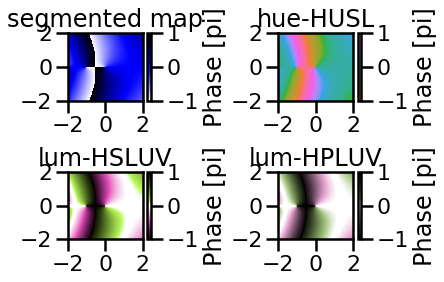

In [2]:
import matplotlib.colors as col
import hsluv # pip install hsluv
import scipy.special # just for the example function

##### generate custom colormaps
def shiftedColorMap(cmap, min_val, max_val, name):
    '''Function to offset the "center" of a colormap. Useful for data with a negative min and positive max and you want the middle of the colormap's dynamic range to be at zero. Adapted from https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered.
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.'''
    epsilon = 0.001
    start, stop = 0.0, 1.0
    min_val, max_val = min(0.0, min_val), max(0.0, max_val) # Edit #2
    midpoint = 1.0 - max_val/(max_val + abs(min_val))
    cdict = {'red': [], 'green': [], 'blue': [], 'alpha': []}
    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)
    # shifted index to match the data
    shift_index = np.hstack([np.linspace(0.0, midpoint, 128, endpoint=False), np.linspace(midpoint, 1.0, 129, endpoint=True)])
    for ri, si in zip(reg_index, shift_index):
        if abs(si - midpoint) < epsilon:
            r, g, b, a = cmap(0.5) # 0.5 = original midpoint.
        else:
            r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = mpl.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap
def make_segmented_cmap(): 
    white = '#ffffff'
    black = '#000000'
    red = '#ff0000'
    blue = '#0000ff'
    anglemap = col.LinearSegmentedColormap.from_list(
        'anglemap', [black, red, white, blue, black], N=256, gamma=1)
    return anglemap

pink_hue = 326;
green_hue = 109;
pink_sat = 75;
green_sat = 85
maxlum = 105; # white at 100
minlum = 0 # black at zero

def make_anglemap( N = 256, use_hpl = True ):
    h = np.ones(N) # hue
    h[:N//2] = pink_hue 
    h[N//2:] = green_hue
    s = np.ones(N) # saturation
    s[:N//2] = pink_sat 
    s[N//2:] = green_sat
    l = np.linspace(minlum, maxlum, N//2) # luminosity
    l = np.hstack( (l,l[::-1] ) )
    
    colorlist = np.zeros((N,3))
    for ii in range(N):
        if use_hpl:
            colorlist[ii,:] = hsluv.hpluv_to_rgb( (h[ii], s[ii], l[ii]) )
        else:
            colorlist[ii,:] = hsluv.hsluv_to_rgb( (h[ii], s[ii], l[ii]) )
    colorlist[colorlist > 1] = 1 # correct numeric errors
    colorlist[colorlist < 0] = 0 
    return col.ListedColormap( colorlist )

def make_anglemap_r( N = 256, use_hpl = True ):
    h = np.ones(N) # hue
    h[:N//2] = green_hue
    h[N//2:] = pink_hue
    s = np.ones(N) # saturation
    s[:N//2] = green_sat
    s[N//2:] = pink_sat 
    l = np.linspace(minlum, maxlum, N//2) # luminosity
    l = np.hstack( (l,l[::-1] ) )
    
    colorlist = np.zeros((N,3))
    for ii in range(N):
        if use_hpl:
            colorlist[ii,:] = hsluv.hpluv_to_rgb( (h[ii], s[ii], l[ii]) )
        else:
            colorlist[ii,:] = hsluv.hsluv_to_rgb( (h[ii], s[ii], l[ii]) )
    colorlist[colorlist > 1] = 1 # correct numeric errors
    colorlist[colorlist < 0] = 0 
    return col.ListedColormap( colorlist )

N = 256
segmented_cmap = make_segmented_cmap()
flat_huslmap = col.ListedColormap(sns.color_palette('husl',N))
hsluv_anglemap = make_anglemap( use_hpl = False )
hpluv_anglemap = make_anglemap( use_hpl = True )
hsluv_anglemap_r = make_anglemap_r( use_hpl = False )


##### generate data grid
x = np.linspace(-2,2,N)
y = np.linspace(-2,2,N)
z = np.zeros((len(y),len(x))) # make cartesian grid
for ii in range(len(y)): 
    z[ii] = np.arctan2(y[ii],x) # simple angular function
    z[ii] = np.angle(scipy.special.gamma(x+1j*y[ii])) # some complex function

##### plot with different colormaps
fig = plt.figure(1)
fig.clf()
colormapnames = ['segmented map', 'hue-HUSL', 'lum-HSLUV', 'lum-HPLUV']
colormaps = [shiftedColorMap(segmented_cmap,.5,1,'phase'), flat_huslmap, hsluv_anglemap, hpluv_anglemap]
halfangle = shiftedColorMap(hsluv_anglemap,.5,1,'phase')
for ii, cm in enumerate(colormaps):
    ax = fig.add_subplot(2, 2, ii+1)
    pmesh = ax.pcolormesh(x, y, z/np.pi, 
        cmap = cm, vmin=-1, vmax=1)
    plt.axis([x.min(), x.max(), y.min(), y.max()])
    cbar = fig.colorbar(pmesh)
    cbar.ax.set_ylabel('Phase [pi]')
    ax.set_title( colormapnames[ii] )
plt.tight_layout();
plt.show()

#divergingcmap = hsluv_anglemap
cmapforhalf = hsluv_anglemap_r
#divergingcmap = 'hsv'

In [3]:
### settings for adding grid of circles
pitch = 3.0 # 3 um from one peg to the next
rotationdegrees = -339 # 339 degrees of rotation from straight
radius = .55 # radius of circles to draw

xstart = -5.75 
ystart = 10.3

rotation = rotationdegrees * np.pi / (180)
deltax = pitch * np.cos(rotation)
deltay = pitch * np.sin(rotation)

# create grid about origin
xlist = [i*pitch for i in range(-3,6)]
ylist = [i*pitch for i in range(-6,4)]
#display(xlist)

"""    grid = np.meshgrid(xlist,ylist)
print(grid)"""

# rotate grid

# Generate a meshgrid and rotate it by RotRad radians.
# source: https://stackoverflow.com/questions/29708840/rotate-meshgrid-with-numpy
def DoRotation(xspan, yspan, RotRad=0):
    """Generate a meshgrid and rotate it by RotRad radians."""

    # Clockwise, 2D rotation matrix
    RotMatrix = np.array([[np.cos(RotRad),  np.sin(RotRad)],
                          [-np.sin(RotRad), np.cos(RotRad)]])

    x, y = np.meshgrid(xspan, yspan)
    return np.einsum('ji, mni -> jmn', RotMatrix, np.dstack([x, y]))

rotated = DoRotation(xlist,ylist, RotRad=rotation)
#display(rotated)

# translate grid to xstart and ystart
rottrans = rotated.copy()
rottrans[0] = rotated[0]+xstart
rottrans[1] = rotated[1]+ystart

#display(rottrans)

# create tuple list

xs = (rottrans[0]).flatten()
ys = (rottrans[1]).flatten()
coordlist = []
for i in range(len(xs)):
    # only add circle to the coordlist if it's in the mapped region
    if xs[i]>-13.1 and xs[i] < 8.5 and ys[i] > -4 and ys[i] < 17:
        coordlist.append((xs[i], ys[i]))

#display(coordlist)
display(len(coordlist))

# two removed pegs create resonators
coordlist.remove((-4.024362569144298, 6.424154871872494))
coordlist.remove((-0.7990510232365908, 14.826378710347306))


display(len(coordlist))
#display(coordlist)


""" Horrible hack for rotating the image 90 degrees to the right """
def rotatehack(df):
    rotatedf = df.transpose()
    rotatedf.index = -rotatedf.index # I know, it's such a bad hack.
    return rotatedf

# Swap tuple elements in list of tuples 
coordlistrot = [(coord[1], -coord[0]) for coord in coordlist] 

51

49

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


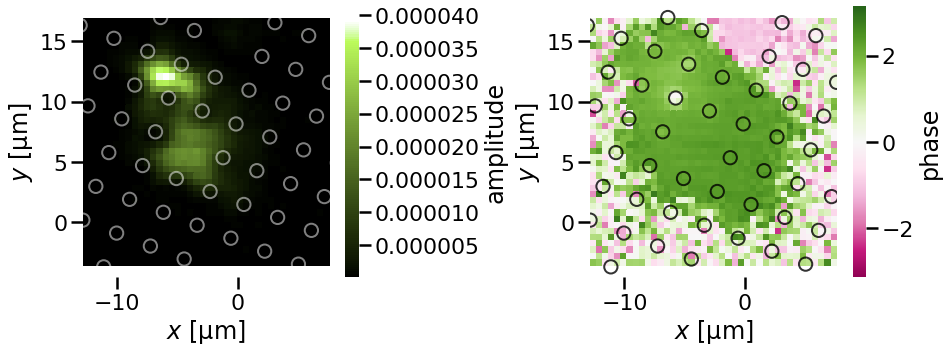

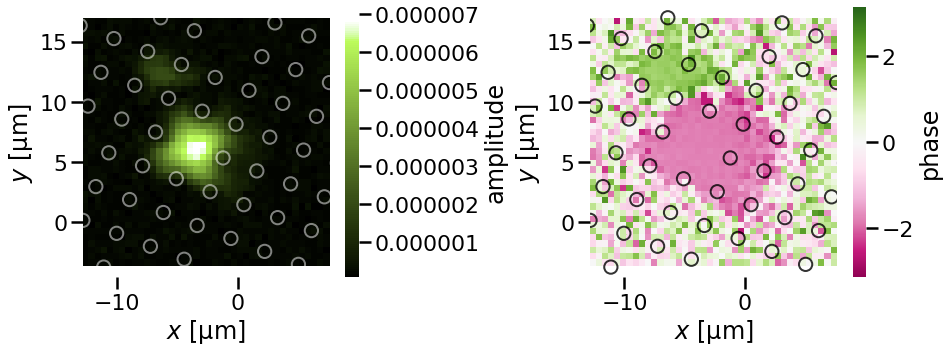

In [4]:
############### Mac vs Windows ##############
#folder1 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/2019/08/09/'
#folder2 = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/2019/07/30/'
folder1 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\2019\08\09'
folder2 = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\2019\07\30'

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
doubleresonatordata = (amp1)
# set white at max, cut colorbar in half
vmin = np.array(doubleresonatordata).min()
vmax = np.array(doubleresonatordata).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(doubleresonatordata, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5)
        plt.gca().add_artist(thiscircle)


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
plt.tight_layout();


file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = amp2
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5)
        plt.gca().add_artist(thiscircle)

plt.sca(ax4) 
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
def add_sizebar(ax, size):
    asb = AnchoredSizeBar(ax.transData,
                          size,
                          str(size) + u' μm',
                          loc='lower right',
                          #bbox_to_anchor=(.5,.5),
                          size_vertical=.4,
                          pad=0.1, borderpad=0.5, sep=5,
                          frameon=False)
    ax.add_artist(asb)

    ## uncommenting the following line will create a sizebar a little bit covering the plot
#add_sizebar(ax4, 10)



plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:48: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:49: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


125.04954452286657
-52.449229049178314
Phase difference (deg):
-177.49877357204488


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:107: RuntimeWarning: invalid value encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:119: RuntimeWarning: invalid value encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:176: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:177: UserWarning: Pandas doesn't allow columns to 

96.77391560379469
-101.13767980377442
Phase difference (deg):
-197.9115954075691


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:231: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:231: RuntimeWarning: invalid value encountered in log


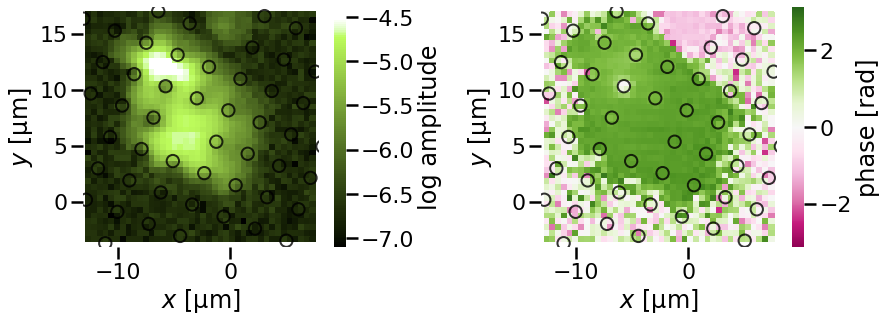

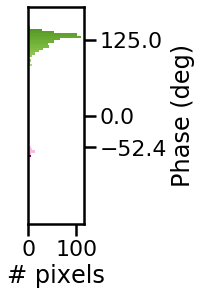

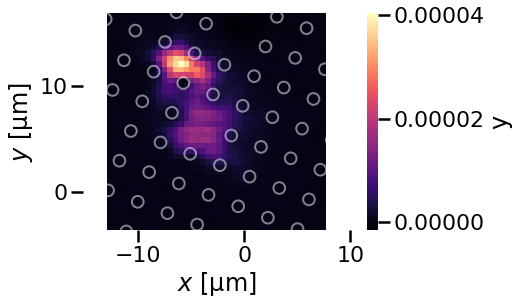

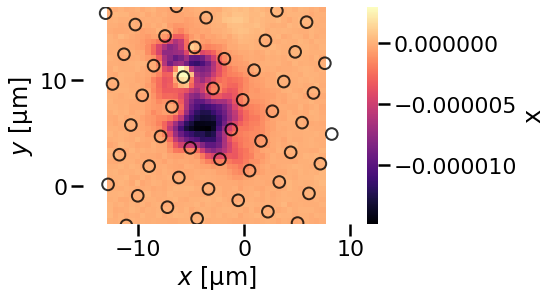

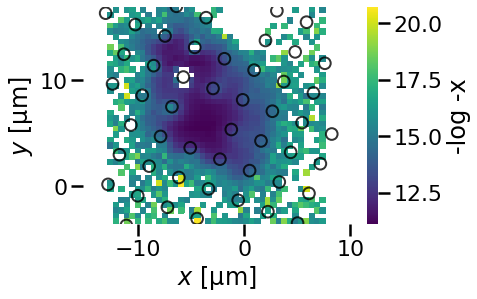

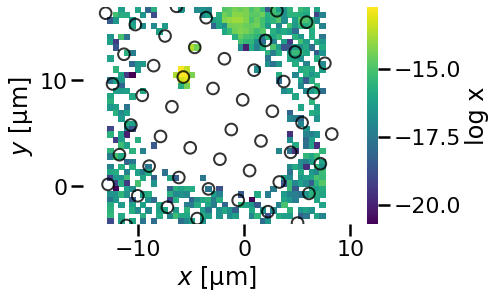

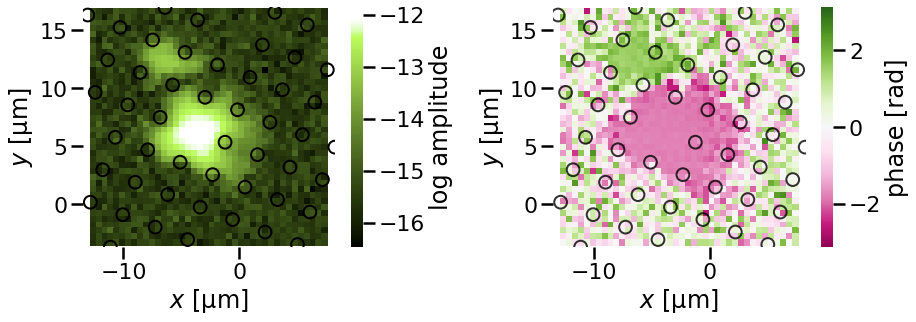

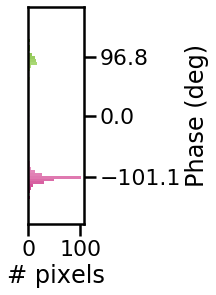

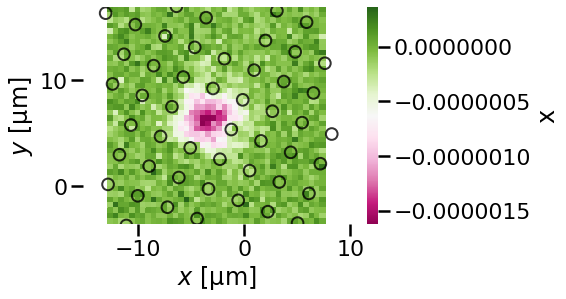

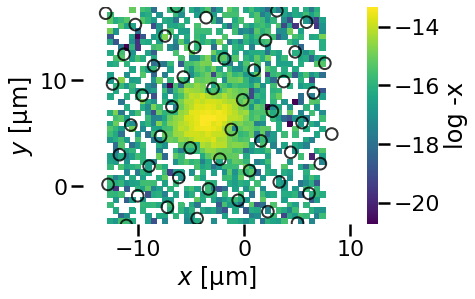

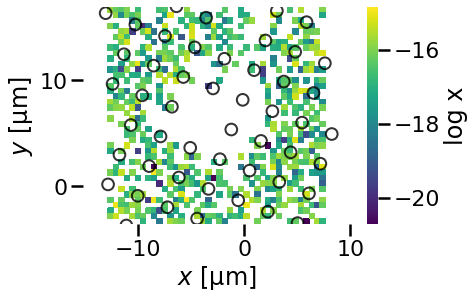

In [30]:
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.8,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log10(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase [rad]', vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
plt.tight_layout();

# Phase histogram 1
df.phasedeg = np.rad2deg(df.phase)
df.rnorm = df.r/df.r.max()
plt.figure(figsize=(1,4))
mk = df.rnorm > 0.01;
n, bins, patches = plt.hist(df.phasedeg[mk], bins=60,color=('#276419'), orientation='horizontal');
plt.ylabel('Phase (deg)')
plt.xlabel('# pixels')
mask100 = df.phasedeg[mk] > 80
maskm100 = df.phasedeg[mk] < 20
print (df.phasedeg[mk][mask100].mean())
print (df.phasedeg[mk][maskm100].mean())
plt.yticks([df.phasedeg[mk][mask100].mean() ,0, df.phasedeg[mk][maskm100].mean()])
plt.ylim(-180,180)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskm100].mean() - df.phasedeg[mk][mask100].mean())

## color bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers = includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))


plt.figure()
y1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'y').sort_index(axis = 0, ascending = False) 

myheatmap(y1, 'y') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5)
        plt.gca().add_artist(thiscircle)

plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x') 
#          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(-np.log(-x1), '-log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)
        
file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']


fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(13.23,5))

plt.sca(ax3)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp2)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax3.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = 1)
        plt.gca().add_artist(thiscircle)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase2, 'phase [rad]',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax4.axis('equal');

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.tight_layout();


# Phase histogram 2
df.phasedeg = np.rad2deg(df.phase)
df.rnorm = df.r/df.r.max()
plt.figure(figsize=(1,4))
mk = df.rnorm > 0.05;
n, bins, patches = plt.hist(df.phasedeg[mk], bins=60,color=('#276419'),orientation='horizontal');
plt.ylabel('Phase (deg)')
plt.xlabel('# pixels')
mask100 = df.phasedeg[mk] > 80
maskm100 = df.phasedeg[mk] < 20
print (df.phasedeg[mk][mask100].mean())
print (df.phasedeg[mk][maskm100].mean())
plt.yticks([df.phasedeg[mk][mask100].mean(), 0,df.phasedeg[mk][maskm100].mean() ])
plt.ylim(-180,180)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskm100].mean() - df.phasedeg[mk][mask100].mean())
## color bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.figure()
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap=divergingcmap);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(-x1), 'log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if add_circle:
    for coords in coordlist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8)
        plt.gca().add_artist(thiscircle)

96.77391560379469
Standard dev:
11.97532647643399
Standard error:
1.4416598938461045
Second peak:
-101.13767980377442
Standard dev:
19.15868387578558
Stderr:
1.155312107145686
Phase difference (deg):-197.9115954075691 ± 1.8474656463495516


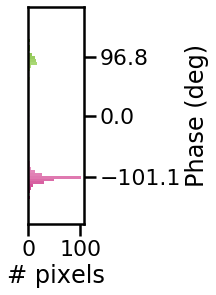

In [6]:
# Phase histogram 2
df.phasedeg = np.rad2deg(df.phase)
df.rnorm = df.r/df.r.max()
plt.figure(figsize=(1,4))
mk = df.rnorm > 0.05;
n, bins, patches = plt.hist(df.phasedeg[mk], bins=60,color=('#276419'),orientation='horizontal');
plt.ylabel('Phase (deg)')
plt.xlabel('# pixels')
mask100 = df.phasedeg[mk] > 80
maskm100 = df.phasedeg[mk] < 20
print (df.phasedeg[mk][mask100].mean())
print("Standard dev:")
print (df.phasedeg[mk][mask100].std())
print("Standard error:")
sterr = df.phasedeg[mk][mask100].std()/np.sqrt(len(df.phasedeg[mk][mask100]))
print(sterr)
print("Second peak:")
print (df.phasedeg[mk][maskm100].mean())
print("Standard dev:")
print (df.phasedeg[mk][maskm100].std())
print("Stderr:")
stderr2= df.phasedeg[mk][maskm100].std()/np.sqrt(len(df.phasedeg[mk][maskm100]))
print(stderr2)

plt.yticks([df.phasedeg[mk][mask100].mean(), 0,df.phasedeg[mk][maskm100].mean() ])
plt.ylim(-180,180)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):" + str(df.phasedeg[mk][maskm100].mean() - df.phasedeg[mk][mask100].mean()) + " ± " + str(np.sqrt(sterr**2+stderr2**2)));



## color bins
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers = includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)

col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
    


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:111: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:112: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


125.04954452286657
-52.449229049178314
Phase difference (deg):
-177.49877357204488


C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:230: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:231: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access


96.77391560379469
-101.13767980377442
Phase difference (deg):
-197.9115954075691
File saved: 
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\modemap_export.pdf


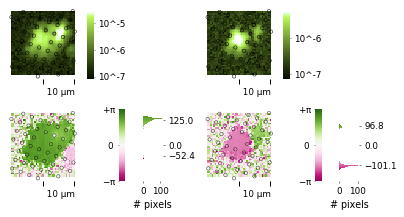

In [37]:
sns.set_context('paper') # makes text sized for paper

# pip install matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar

saving = True
add_circle= True
rotating = True

file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum_15.16MHz_1104325' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']

widths = [2.5,.7,2.5,.7]
heights = [1, 1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

## (2,2) size.   #3.37, 2.8 is tight; 3.15 height gives space for scale bar.
sty={'figsize':(5.5,2.9), "constrained_layout":True, "gridspec_kw": gs_kw}

## (1,2) size
#sty={'figsize':(3.37,1.43), "constrained_layout":True}



fig, ((ax1, blank1, ax2, blank2),(ax3, phist1, ax4, phist2)) = plt.subplots(2,4, **sty)
#fig, (ax3, ax4) = plt.subplots(1, 2, **sty)

blank1.axis('off')
blank2.axis('off')


## label text for scalebar
tenum = u'             10 μm'

#plt.suptitle(file + '\n\n');

plt.sca(ax1) 

amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log10(amp1)
if rotating:
    data = rotatehack(data)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

axx,cbar = myheatmap(data,  norm = greennorm, return_cbar=True,
          cmap=cmapforhalf);
plt.xlabel('')
plt.ylabel('')
ax1.axis('equal')
topx = data.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
cbar1 = cbar

# decrease number of ticks on colorbar
"""tick_locator = mpl.ticker.MaxNLocator(nbins=4)
cbar.locator = tick_locator
cbar.update_ticks()"""
#cbar.set_ticks([-11, -16])
cbar.set_ticks([-7, -6,-5])
cbar.ax.set_yticklabels(['10^-7', '10^-6','10^-5']) ## make SURE this line is with the one above it

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = 1, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)

plt.sca(ax3) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
data = phase1
if rotating:
    data = rotatehack(data)
axx, cbar = myheatmap(data, return_cbar=True,  vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel('')
plt.ylabel('')
#topx = amp1.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.set_yticklabels(['$-$\u03C0', '0 ', '$+$\u03C0'],ha='right')  # make sure this line is joined with the one above it.
cbar.ax.yaxis.set_tick_params(pad=1)  # your number may vary
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
cbar2 = cbar

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)
        
plt.sca(phist1) # Phase histogram 1
df.phasedeg = np.rad2deg(df.phase)
df.rnorm = df.r/df.r.max()
mk = df.rnorm > 0.01;
n, bins, patches = plt.hist(df.phasedeg[mk], bins=60,color=('#276419'), orientation='horizontal');
#plt.ylabel('Phase (deg)')
plt.xlabel('# pixels')
mask100 = df.phasedeg[mk] > 80
maskm100 = df.phasedeg[mk] < 20
print (df.phasedeg[mk][mask100].mean())
print (df.phasedeg[mk][maskm100].mean())
plt.yticks([df.phasedeg[mk][mask100].mean() ,0, df.phasedeg[mk][maskm100].mean()])
plt.ylim(-180,180)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskm100].mean() - df.phasedeg[mk][mask100].mean())

## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

#plt.tight_layout();
"""if saving:
    plt.savefig(os.path.join(savefolder,file + '.pdf'), dpi=None, facecolor='w', edgecolor='w',
        transparent=False, bbox_inches='tight', pad_inches=0.05,
        metadata=None)"""



file = 'PosGU01Array01.00r0.5p3Array01.00r0.5p3Device1.2Drum1_15.5MHz105133' 
path = os.path.join(folder1,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
#df.r = df.r/df.r.max() 
#print(df) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']



plt.sca(ax2)
amp2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log10(amp2)
if rotating:
    data = rotatehack(data)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

axx, cbar = myheatmap(data,  norm = greennorm, return_cbar=True,
          cmap=cmapforhalf);
plt.xlabel('')
plt.ylabel('')
ax3.axis('equal');
#topx = amp1.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

# decrease number of ticks on colorbar
#cbar.ax.locator_params(nbins=2)
#cbar.set_ticks([-12,-16])
cbar.set_ticks([-7, -6,-5])
cbar.ax.set_yticklabels(['10^-7', '10^-6','10^-5']) ## make SURE this line is with the one above it
cbar3= cbar

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:        
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = 1, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)

plt.sca(ax4)
phase2 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
data = phase2
if rotating:
    data = rotatehack(data)
axx, cbar = myheatmap(data, return_cbar=True, vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
plt.xlabel('')
plt.ylabel('')
ax4.axis('equal');
#topx = amp1.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([tenum, ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot
cbar.ax.yaxis.set_ticks_position('left')
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.set_yticklabels(['$-$\u03C0', '0 ', '$+$\u03C0'],ha='right')  # make sure this line is joined with the one above it.
cbar.ax.yaxis.set_tick_params(pad=1)  # your number may vary
cbar4 = cbar


for cbar in [cbar1, cbar2, cbar3, cbar4]:
    cbar.ax.tick_params(length=cbarticklength, width=tickwidth)


# add_sizebar(ax4, 10) # creates a scalebar a little bit covering the plot.

if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:        
        thiscircle = plt.Circle(coords, radius=radius, color='k', fill = None, alpha = .8, lw=0.5,)#linestyle='dashed')
        plt.gca().add_artist(thiscircle)
        
        
plt.sca(phist2) # Phase histogram 2
df.phasedeg = np.rad2deg(df.phase)
df.rnorm = df.r/df.r.max()
mk = df.rnorm > 0.05;
n, bins, patches = plt.hist(df.phasedeg[mk], bins=60,color=('#276419'),orientation='horizontal');
#plt.ylabel('Phase (deg)')
plt.xlabel('# pixels')
mask100 = df.phasedeg[mk] > 80
maskm100 = df.phasedeg[mk] < 20
print (df.phasedeg[mk][mask100].mean())
print (df.phasedeg[mk][maskm100].mean())
plt.yticks([df.phasedeg[mk][mask100].mean(), 0,df.phasedeg[mk][maskm100].mean() ])
plt.ylim(-180,180)
ax = plt.gca()
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
print("Phase difference (deg):")
print (df.phasedeg[mk][maskm100].mean() - df.phasedeg[mk][mask100].mean())
## color bins, https://stackoverflow.com/questions/23061657/plot-histogram-with-colors-taken-from-colormap
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_Centers=includeendpoints(bin_centers)
# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= max(col)
cm = plt.cm.get_cmap(divergingcmap)
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))
sns.despine(left=True, right=True, bottom=True)

for ax in [phist1, phist2]:
    ax.tick_params(direction='out', length=ticklength, width=tickwidth)
        
#plt.tight_layout();

if saving:
    plt.savefig(os.path.join(savefolder, 'modemap_export.pdf'), dpi=None, facecolor='w',  edgecolor='w',
        transparent=False, bbox_inches='tight', pad_inches=0,
        metadata=None)
    print('File saved: ')
else:
    print('File not overwritten:')
print(os.path.join(savefolder, 'modemap_export.pdf'))



sns.set_context('poster') # makes text larger again

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


PosGU01Arrray01.00r0.5p3Device0.0Drum210V_15.6MHz100338


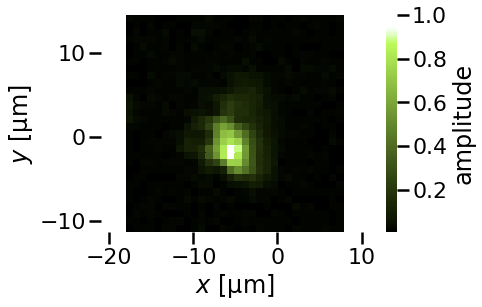

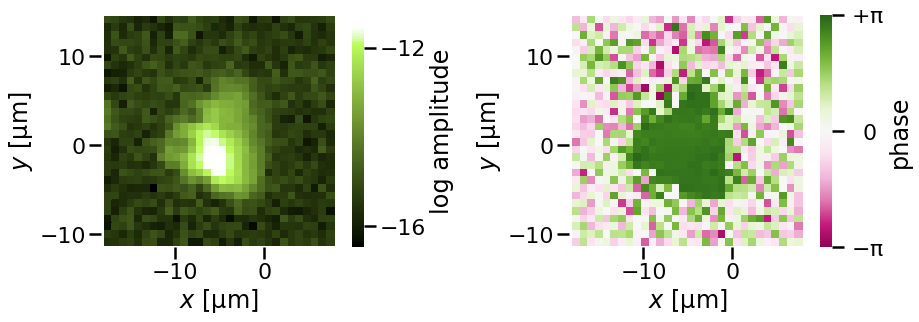

In [8]:
## single resonator

file = 'PosGU01Arrray01.00r0.5p3Device0.0Drum210V_15.6MHz100338' 
path = os.path.join(folder2,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 

df['X um']=df['Green X']
df['Y um']= df['Green Y']


plt.figure()
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False)

singleresdata = (amp1)/(amp1.max().max())
max2 = amp1.max().max()
# set white at max, cut colorbar in half
vmin = np.array(singleresdata).min()
vmax = np.array(singleresdata).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

ax, cbar = myheatmap(singleresdata, 'amplitude', norm = greennorm,
                  cmap=cmapforhalf, return_cbar=True);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax.axis('equal')
#cbar.set_ticks([-16,-12])

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

_, cbar1 = myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf, return_cbar=True);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')
cbar1.set_ticks([-16,-12])



plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
_, cbar = myheatmap(phase1, 'phase',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap, return_cbar=True);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.set_yticklabels(['$-$\u03C0', '0 ', '$+$\u03C0'],ha='right')  # make sure this line is joined with the one above it.
cbar.ax.yaxis.set_tick_params(pad=40)  # your number may vary

print(file)
plt.tight_layout();

(-13.6713401055, 3.5700392049999996, -9.612075806, 9.362697225999998)

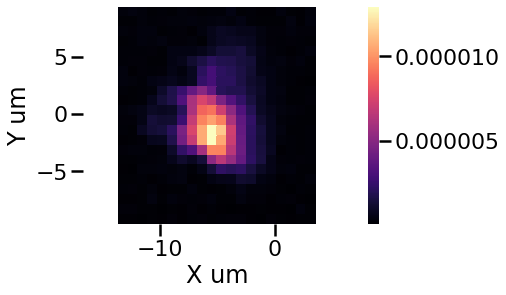

In [9]:
ax = myheatmap(amp1.iloc[6:-2,5:-5])
ax.axis('equal')

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238


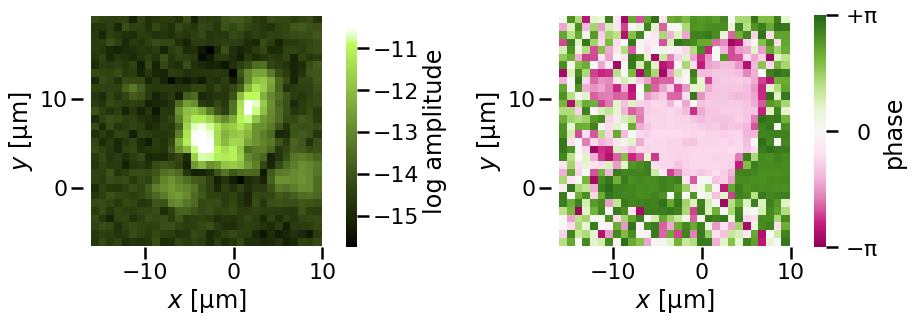

In [10]:
file = 'PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238' 
path = os.path.join(folder2,file)
df = pd.read_csv(os.path.join(path, 'Demod1.csv'), skiprows = 2) 
df['X um']=df['Green X']
df['Y um']= df['Green Y']

fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
_,cbar = myheatmap(phase1, 'phase',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap, return_cbar=True);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
cbar.set_ticks([-np.pi, 0, np.pi])
cbar.ax.set_yticklabels(['$-$\u03C0', '0 ', '$+$\u03C0'],ha='right')  # make sure this line is joined with the one above it.
cbar.ax.yaxis.set_tick_params(pad=40)  # your number may vary

print(file)
plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


PosGU01Arrray01.00r0.5p3Device0.1Drum2_10V114238


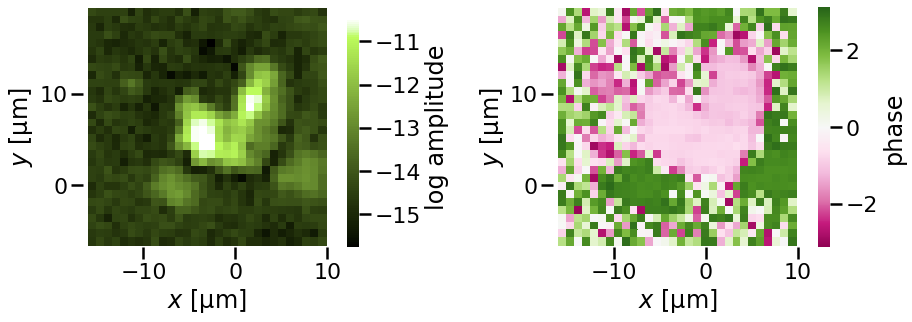

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2,  figsize=(13.23,5))

#plt.suptitle(file + '\n\n');

plt.sca(ax1)
amp1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'r').sort_index(axis = 0, ascending = False) 
data = np.log(amp1)
# set white at max, cut colorbar in half
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)

myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
ax1.axis('equal')


plt.sca(ax2) 
phase1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'phase').sort_index(axis = 0, ascending = False) 
myheatmap(phase1, 'phase',vmin=-np.pi, vmax = np.pi, cmap=divergingcmap);
ax2.axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')

print(file)
plt.tight_layout();

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


'plt.figure()\nmyheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))'

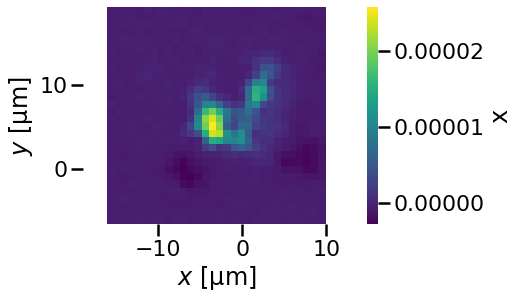

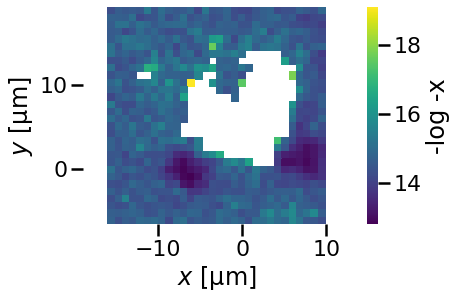

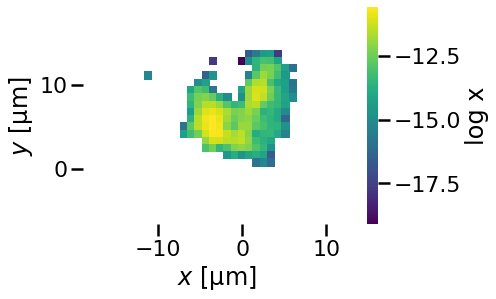

In [12]:
x1 = df.pivot_table(index = 'Y um', columns = 'X um', values = 'x').sort_index(axis = 0, ascending = False) 

myheatmap(x1, 'x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(-np.log(-x1), '-log -x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

plt.figure()
myheatmap(np.log(x1), 'log x', 
          cmap='viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

"""plt.figure()
myheatmap(np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))"""

In [13]:
#np.nanmax(np.array(-np.log(-x1)),np.array(np.log(x1)))

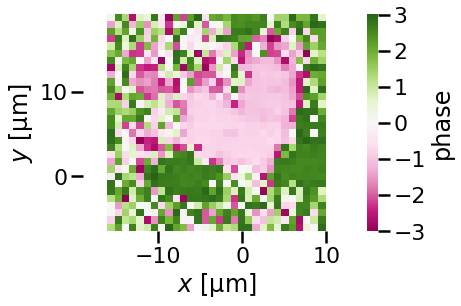

In [14]:

    
# set midpoint at zero.
vmin = np.array(phase1).min()
vmax = np.array(phase1).max()
norm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=0)


## Plot with a norm at 0
myheatmap(phase1, 'phase', norm = norm,
          cmap=divergingcmap);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

In [15]:
if plot3d:
    from mpl_toolkits import mplot3d
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(phase1.columns,phase1.index )
    ax.plot_surface(X,Y,phase1, 
                    norm=norm,  # set midpoint at 0.
                    antialiased=False,
                    cmap=divergingcmap )
    plt.xlabel(phase1.columns.name)
    plt.ylabel(phase1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


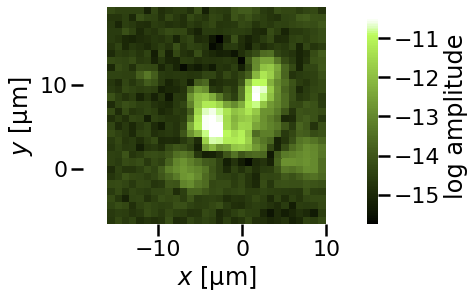

In [16]:
## Cut colorbar in half.

data = np.log(amp1)

# set white at max.
vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=vmin, vmax=vmax, midpoint=vmax)


## Plot with a midpoint at 0.
myheatmap(data, 'log amplitude', norm = greennorm,
          cmap=cmapforhalf);
plt.gca().axis('equal');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]');

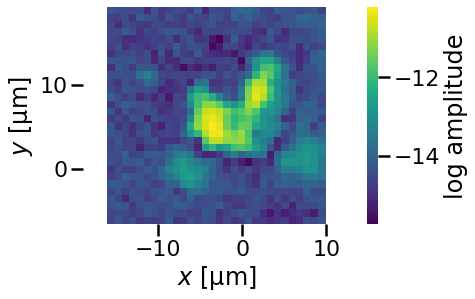

In [17]:
myheatmap(np.log(amp1), 'log amplitude', cmap = 'viridis');
plt.xlabel(u'$x$ [μm]')
plt.ylabel(u'$y$ [μm]')
plt.gca().axis('equal')

if plot3d:
    plt.figure()
    ax = plt.axes(projection='3d')
    X, Y = np.meshgrid(amp1.columns,amp1.index )
    ax.plot_surface(X,Y,(amp1), 
                    antialiased=False,
                    cmap='viridis', )
    plt.xlabel(amp1.columns.name)
    plt.ylabel(amp1.index.name)
    ax.set_title(file);
    ax.view_init(elev=60., azim=0)

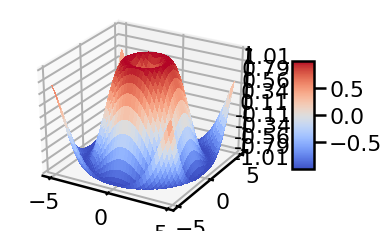

In [18]:
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

C:\Users\vhorowit\AppData\Local\conda\conda\envs\py36\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


Figure saved:
\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports\ResCurvesAndModeMaps.pdf


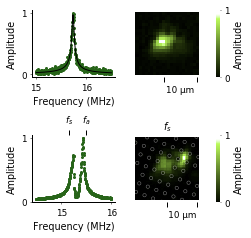

In [19]:
#### Want to plot together: single resonance peak, mode map, double resonance peak, mode map
import lmfit as lf
from lmfit.models import DampedOscillatorModel

widths = [1,1]
heights = [1, 1]
gs_kw = dict(width_ratios=widths, height_ratios=heights)

sns.set_context('paper')
# subplotssty={'figsize':(3.37,3.3), "constrained_layout":True, 'gridspec_kw':gs_kw} # use 3.3 if no plot title
subplotssty={'figsize':(3.37,3.2), "constrained_layout":True, 'gridspec_kw':gs_kw}

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, **subplotssty)

"""Plot single resonator curve"""

## Mac vs Windows
#base = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
#savefolder = '/Volumes/Aleman-Lab/Group/Papers and Abstracts/Coupled Resonator Spatial Imaging/Figures/python_exports/'
base = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves'
savefolder = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Papers and Abstracts\Coupled Resonator Spatial Imaging\Figures\python_exports'
path = os.path.join(base, 'Array01.00r0.5p3Device0.0Drum1_2','Data.csv')
colnames = ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']
df = pd.read_csv(path, names = colnames)

#Find resonant frequency and normalize F and R^2 values
maxR = df['R'].max()
maxFreqIn = (df['R'].idxmax())
max1 = maxR

df['Rnorm'] = (df.R) / (maxR)
df['Fnorm'] = df.F / 10**6
res = df['Fnorm'].values[maxFreqIn]
# Define model
model = DampedOscillatorModel()
model.param_names
# Fit
guessQ = 1000
params = model.make_params(sigma = 1/(2*guessQ), center = res, amplitude = 1 / (guessQ*res))
result = model.fit(df.Rnorm, params, x = df.Fnorm)
# Plot
sty = {'markersize':4, "lw":1}
ax1.plot(df.Fnorm, df.Rnorm, '.', color='#276419' , **sty )
ax1.plot(df.Fnorm, result.best_fit, '-k', **sty)
ax1.set_xlabel('Frequency (MHz)')
ax1.set_ylabel('Amplitude')

""" Plot the mode map for the single resonator """
plt.sca(ax2)
data = singleresdata.iloc[6:-2,4:-4]
if rotating:
    data=rotatehack(data)
#vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=0, vmax=vmax, midpoint=vmax)
_, cbar = myheatmap(data, 'Amplitude', norm = greennorm,
                      cmap=cmapforhalf, return_cbar=True);
#cbar.ax.set_ylim(-1,1)
cbar.set_ticks([1,0])
cbar.ax.tick_params(length=cbarticklength, width=tickwidth)
ax2.axis('equal')

# Create scale-bar
topx = data.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([u'            10 μm', ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

#plt.xlabel(u'$x$ [μm]')
#plt.ylabel(u'$y$ [μm]')
plt.xlabel('')
plt.ylabel('')

""" Double resonant curve """

plt.sca(ax3)
#base = '/Volumes/Aleman-Lab/Group/Projects/GrapheneCoupledResonators/Data/Sample2/ResonanceCurves/'
base = r'\\cas-fs1.uoregon.edu\Material-Science-Institute\Aleman-Lab\Group\Projects\GrapheneCoupledResonators\Data\Sample2\ResonanceCurves'
path = os.path.join(base, 'Array01.00r0.5p3Device1.2Drum1Couping500/Data.csv')
colnames = ['SweepVal', 'F', 'R', 'theta', 'NEP_BW', 'R_ref', 'theta_ref', 'Amp', 'Phase']
df = pd.read_csv(path, names = colnames)
maxR = df['R'].max()
df['Rnorm'] = (df.R) / (maxR)
max3 = maxR
df['Fnorm'] = df.F / 10**6
sty = {'markersize':4}
ax3.plot(df.Fnorm, (df.Rnorm), '.', color=('#276419'),**sty)
ax3.set_xlabel('Frequency (MHz)')
ax3.set_ylabel('Amplitude')
## add marks where the frequencies are
axtop = ax3.twiny()
xlims = ax3.get_xlim()
axtop.set_xlim(xlims)
axtop.tick_params(bottom=False, top=True, left=False, right=False)
axtop.set_xticks([15.16, 15.5])
#axtop.set_xticklabels([])
axtop.set_xticklabels(['$f_s$', '$f_a$'])


""" Mode map corresponding to double resonant curve """

plt.sca(ax4)
max4 = doubleresonatordata.max().max()
data = doubleresonatordata/doubleresonatordata.max().max()
if rotating:
    data = rotatehack(data)
#vmin = np.array(data).min()
vmax = np.array(data).max()
greennorm = MidpointNormalize(vmin=0, vmax=vmax, midpoint=vmax)

_,cbar = myheatmap(data, 'Amplitude', norm = greennorm,
          cmap=cmapforhalf, return_cbar= True);
ax4.axis('equal')
cbar.set_ticks([1,0])
cbar.ax.tick_params(length=cbarticklength, width=tickwidth)


if add_circle:
    if rotating:
        coordinateslist = coordlistrot
    else:
        coordinateslist = coordlist
    for coords in coordinateslist:  
        thiscircle = plt.Circle(coords, radius=radius, color='w', fill = None, alpha = .5, lw = .5)
        plt.gca().add_artist(thiscircle)
        
plt.title('$f_s$')

# Create scale-bar
topx = data.columns.max()
plt.xticks([topx-10, topx])
plt.gca().set_xticklabels([u'           10 μm', ''])
plt.yticks([]) # remove y ticks, since we can use the xticks alone on a square plot

#plt.xlabel(u'$x$ [μm]')
#plt.ylabel(u'$y$ [μm]')
plt.xlabel('')
plt.ylabel('')

for ax in [ ax3, ax1]:
    ax.tick_params(direction='out', length=ticklength, width=tickwidth)
    ax.set_yticks([0,1])
"""    ax.spines['left'].set_linewidth(.5)
    ax.spines['right'].set_linewidth(.5)
    ax.spines['top'].set_linewidth(.5)
    ax.spines['bottom'].set_linewidth(.5)"""
    
sns.despine()
    
savename = 'ResCurvesAndModeMaps.pdf'
plt.savefig(os.path.join(savefolder,savename), bbox_inches='tight',pad_inches=0)
print('Figure saved:')
print(os.path.join(savefolder, savename))

sns.set_context('poster') # make font large again.

In [20]:
print(max1)
print(max2)
print(max3)
print(max4)

1.3699763709130001e-05
1.2934e-05
3.562592373368e-05
4.1342e-05
